Notebook to wranggle behavioral data from LAMF project

1. Pupil
2. Running
3. Licking

In [23]:
import os
import tensortools
import numpy as np
import pandas as pd
import xarray as xr
from tqdm import tqdm
from matplotlib import pyplot as plt
from brain_observatory_analysis.ophys.experiment_loading import start_lamf_analysis, get_recent_expts

import seaborn as sns
sns.set_context('notebook', font_scale=1.5, rc={'lines.markeredgewidth': 2})

from brain_observatory_qc.data_access import from_lims_utilities
import glob
from brain_observatory_analysis.behavior.video_qc import annotation_tools
from mindscope_utilities import general_utilities

%load_ext autoreload
%autoreload 2
%matplotlib inline

import warnings; warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [76]:
experiments_table.session_type.unique()

array(['TRAINING_0_gratings_autorewards_15min', 'TRAINING_1_gratings',
       'TRAINING_2_gratings_flashed', 'TRAINING_3_images_A_10uL_reward',
       'TRAINING_4_images_A_training', 'TRAINING_5_images_A_epilogue',
       'TRAINING_5_images_A_handoff_ready', 'OPHYS_1_images_A',
       'OPHYS_4_images_B', 'OPHYS_6_images_B'], dtype=object)

In [36]:
experiments_table = start_lamf_analysis()

Should be on 2.13.5 version of allensdk branch, let MJD know if not


In [37]:
experiments_table.mouse_name.unique()

array(['Gold', 'Silicon', 'Silver', 'Bronze', 'Copper', 'Titanium',
       'Aluminum', 'Mercury', 'Iron', 'Indium', 'Lead', 'Tin'],
      dtype=object)

In [38]:
%%time
experiment_id = 1287634566 # Lead mouse, 175um, Gad2xAi195

dataset = cache.get_behavior_ophys_experiment(experiment_id)

CPU times: total: 31.2 s
Wall time: 37.5 s


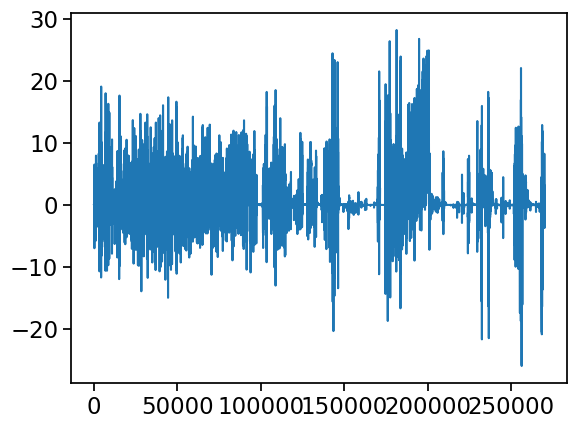

In [42]:
plt.plot(dataset.running_speed.speed)

In [71]:
def add_stim_color_span(dataset, ax, xlim=None, color=None, label_changes=False, label_omissions=False):
    """
    adds a vertical span for all stimulus presentations contained within xlim
    xlim is a time in seconds during a behavior session
    if label_changes is True, changes will be blue and all other flashes will be gray
    if label_changes is False, each flash will be colored according to image identity
    if label_omissions is True, a dotted line will be shown at the time of omission
    if a color is provided, all stimulus presentations will be that color
    """
    # set default alpha. If label_changes=True, alphas will be reset below.
    alpha = 0.3
    # get stim table
    stim_table = dataset.stimulus_presentations.copy()
    # remove omissions because they dont get labeled
    #     stim_table = stim_table[stim_table.omitted == False].copy()
    # get all images & assign colors (image colors wont be used if a color is provided or if label_changes is True)
    images = np.sort(stim_table[stim_table.omitted == False].image_name.unique())
    image_colors = sns.color_palette("hls", len(images))
    # limit to time window if provided
    if xlim is not None:
        stim_table = stim_table[(stim_table.start_time >= xlim[0]) & (stim_table.stop_time <= xlim[1])]
    # loop through stimulus presentations and add a span with appropriate color
    for idx in stim_table.index:
        start_time = stim_table.loc[idx]['start_time']
        stop_time = stim_table.loc[idx]['stop_time']
        image_name = stim_table.loc[idx]['image_name']
        image_index = stim_table.loc[idx]['image_index']
        if image_name == 'omitted':
            if label_omissions:
                ax.axvline(x=start_time, ymin=0, ymax=1, linestyle='--', color=sns.color_palette()[9])
        else:
            if label_changes:
                if stim_table.loc[idx]['is_change']:  # if its a change, make it blue with higher alpha
                    image_color = sns.color_palette()[0]
                    alpha = 0.5
                else:  # if its a non-change make it gray with low alpha
                    image_color = 'gray'
                    alpha = 0.25
            else:
                if color is None:
                    image_color = image_colors[image_index]
                else:
                    image_color = color
            addSpan(ax, start_time, stop_time, color=image_color, alpha=alpha)
    return ax

def addSpan(ax, amin, amax, color='k', alpha=0.3, axtype='x', zorder=1):
    """
    adds a vertical span to an axis
    """
    if axtype == 'x':
        ax.axvspan(amin, amax, facecolor=color, edgecolor='none', alpha=alpha, linewidth=0, zorder=zorder)
    if axtype == 'y':
        ax.axhspan(amin, amax, facecolor=color, edgecolor='none', alpha=alpha, linewidth=0, zorder=zorder)



In [69]:
def plot_behavior_timeseries_stacked(dataset, start_time, duration_seconds=20,
                                     label_changes=True, label_omissions=True,
                                     save_dir=None, ax=None):
    """
    Plots licking behavior, rewards, running speed, and pupil area for a defined window of time.
    Each timeseries gets its own row. If label_changes=True, all flashes are gray, changes are blue.
    If label_changes=False, unique colors are given to each image.
    If label_omissions=True, a dotted line will be plotted at the time of omissions.
    """

    if label_changes:
        suffix = '_changes'
    else:
        suffix = '_colors'

    xlim_seconds = [start_time - (duration_seconds / 4.), start_time + duration_seconds * 2]
    print(np.shape(xlim_seconds))

    lick_timestamps = dataset.licks.timestamps.values
    licks = np.ones(len(lick_timestamps))
    licks[:] = -2

    reward_timestamps = dataset.rewards.timestamps.values
    rewards = np.zeros(len(reward_timestamps))
    rewards[:] = -4

    # get run speed trace and timestamps
    running_speed = dataset.running_speed.speed.values
    running_timestamps = dataset.running_speed.timestamps.values
    # limit running trace to window so yaxes scale properly
    start_ind = np.where(running_timestamps < xlim_seconds[0])[0][-1]
    stop_ind = np.where(running_timestamps > xlim_seconds[1])[0][0]
    running_speed = running_speed[start_ind:stop_ind]
    running_timestamps = running_timestamps[start_ind:stop_ind]

    # get pupil width trace and timestamps
    eye_tracking = dataset.eye_tracking.copy()
    pupil_diameter = eye_tracking.pupil_width.values
    pupil_diameter[eye_tracking.likely_blink == True] = np.nan
    pupil_timestamps = eye_tracking.timestamps.values
    # smooth pupil diameter
    from scipy.signal import medfilt
    pupil_diameter = medfilt(pupil_diameter, kernel_size=5)
    # limit pupil trace to window so yaxes scale properly
    start_ind = np.where(pupil_timestamps < xlim_seconds[0])[0][-1]
    stop_ind = np.where(pupil_timestamps > xlim_seconds[1])[0][0]
    pupil_diameter = pupil_diameter[start_ind:stop_ind]
    pupil_timestamps = pupil_timestamps[start_ind:stop_ind]

    if ax is None:
        figsize = (15, 5)
        fig, ax = plt.subplots(4, 1, figsize=figsize, sharex=True, gridspec_kw={'height_ratios': [1, 1, 3, 3]})
        ax = ax.ravel()

    colors = sns.color_palette()

    ax[0].plot(lick_timestamps, licks, '|', label='licks', color=colors[3], markersize=10)
    ax[0].set_yticklabels([])
    ax[0].set_ylabel('licks', rotation=0, horizontalalignment='right', verticalalignment='center')
    ax[0].tick_params(which='both', bottom=False, top=False, right=False, left=False,
                      labelbottom=False, labeltop=False, labelright=False, labelleft=False)

    ax[1].plot(reward_timestamps, rewards, 'o', label='rewards', color=colors[8], markersize=10)
    ax[1].set_yticklabels([])
    ax[1].set_ylabel('rewards', rotation=0, horizontalalignment='right', verticalalignment='center')
    ax[1].tick_params(which='both', bottom=False, top=False, right=False, left=False,
                      labelbottom=False, labeltop=False, labelright=False, labelleft=False)

    ax[2].plot(running_timestamps, running_speed, label='running_speed', color=colors[2], zorder=100)
    ax[2].set_ylabel('running\nspeed\n(cm/s)', rotation=0, horizontalalignment='right', verticalalignment='center')
    ax[2].set_ylim(ymin=-8)

    ax[3].plot(pupil_timestamps, pupil_diameter, label='pupil_diameter', color=colors[4], zorder=0)
    ax[3].set_ylabel('pupil\ndiameter\n(pixels)', rotation=0, horizontalalignment='right', verticalalignment='center')

    for i in range(4):
        ax[i] = add_stim_color_span(dataset, ax[i], xlim=xlim_seconds, label_changes=label_changes, label_omissions=label_omissions)
        ax[i].set_xlim(xlim_seconds)
        ax[i].tick_params(which='both', bottom=False, top=False, right=False, left=True,
                          labelbottom=False, labeltop=False, labelright=False, labelleft=True)
        sns.despine(ax=ax[i], bottom=True)
    sns.despine(ax=ax[i], bottom=False)

    # label bottom row of plot
    ax[i].set_xlabel('time in session (seconds)')
    ax[i].tick_params(which='both', bottom=True, top=False, right=False, left=True,
                      labelbottom=True, labeltop=False, labelright=False, labelleft=True)
    # add title to top row
    #metadata_string = utils.get_metadata_string(dataset.metadata)
    #ax[0].set_title(metadata_string)

    plt.subplots_adjust(hspace=0)
    if save_dir:
        folder = 'behavior_timeseries_stacked'
        utils.save_figure(fig, figsize, save_dir, folder, metadata_string + '_' + str(int(start_time)) + '_' + suffix,
                          formats=['.png', '.pdf'])
    return ax


(2,)


array([<AxesSubplot:ylabel='licks'>, <AxesSubplot:ylabel='rewards'>,
       <AxesSubplot:ylabel='running\nspeed\n(cm/s)'>,
       <AxesSubplot:xlabel='time in session (seconds)', ylabel='pupil\ndiameter\n(pixels)'>],
      dtype=object)

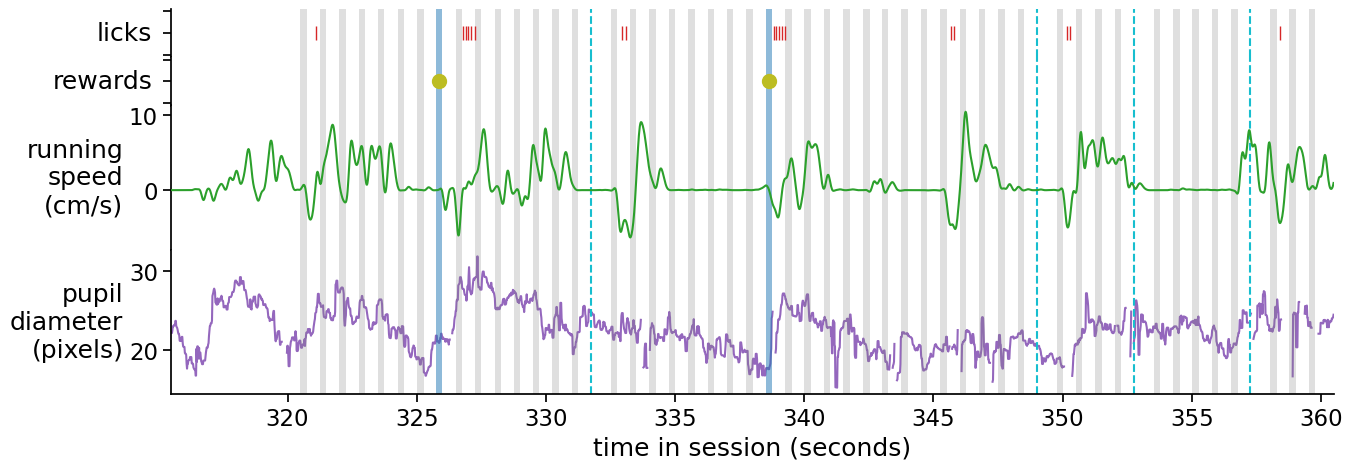

In [72]:
start_time = dataset.stimulus_presentations.start_time.values[0]
plot_behavior_timeseries_stacked(dataset, start_time, duration_seconds=20,
                                     label_changes=True, label_omissions=True,
                                     save_dir=None, ax=None)

In [52]:
duration_seconds = 20
start_times = start_time.values
xlim_seconds = [start_times - (duration_seconds / 4.), start_times + duration_seconds * 2]

In [56]:
np.shape(xlim_seconds)

(2, 4805)